In [3]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

LOWER_DELETION_SIZE_LIMIT = 4000
UPPER_DELETION_SIZE_LIMIT = 10000
DELETION_ALLELE_FREQ_THRESHOLD = 0.00001

## The depletion of genetic variation is expected to be more pronounced in coding sequence than in intronic sequence 

Tom has shown that deletion deserts are enriched for coding sequence over genic sequence (coding sequence plus intronic sequence, etc), 
and that this enrichment becomes more pronounced as the expected degree of negative selection increases. 

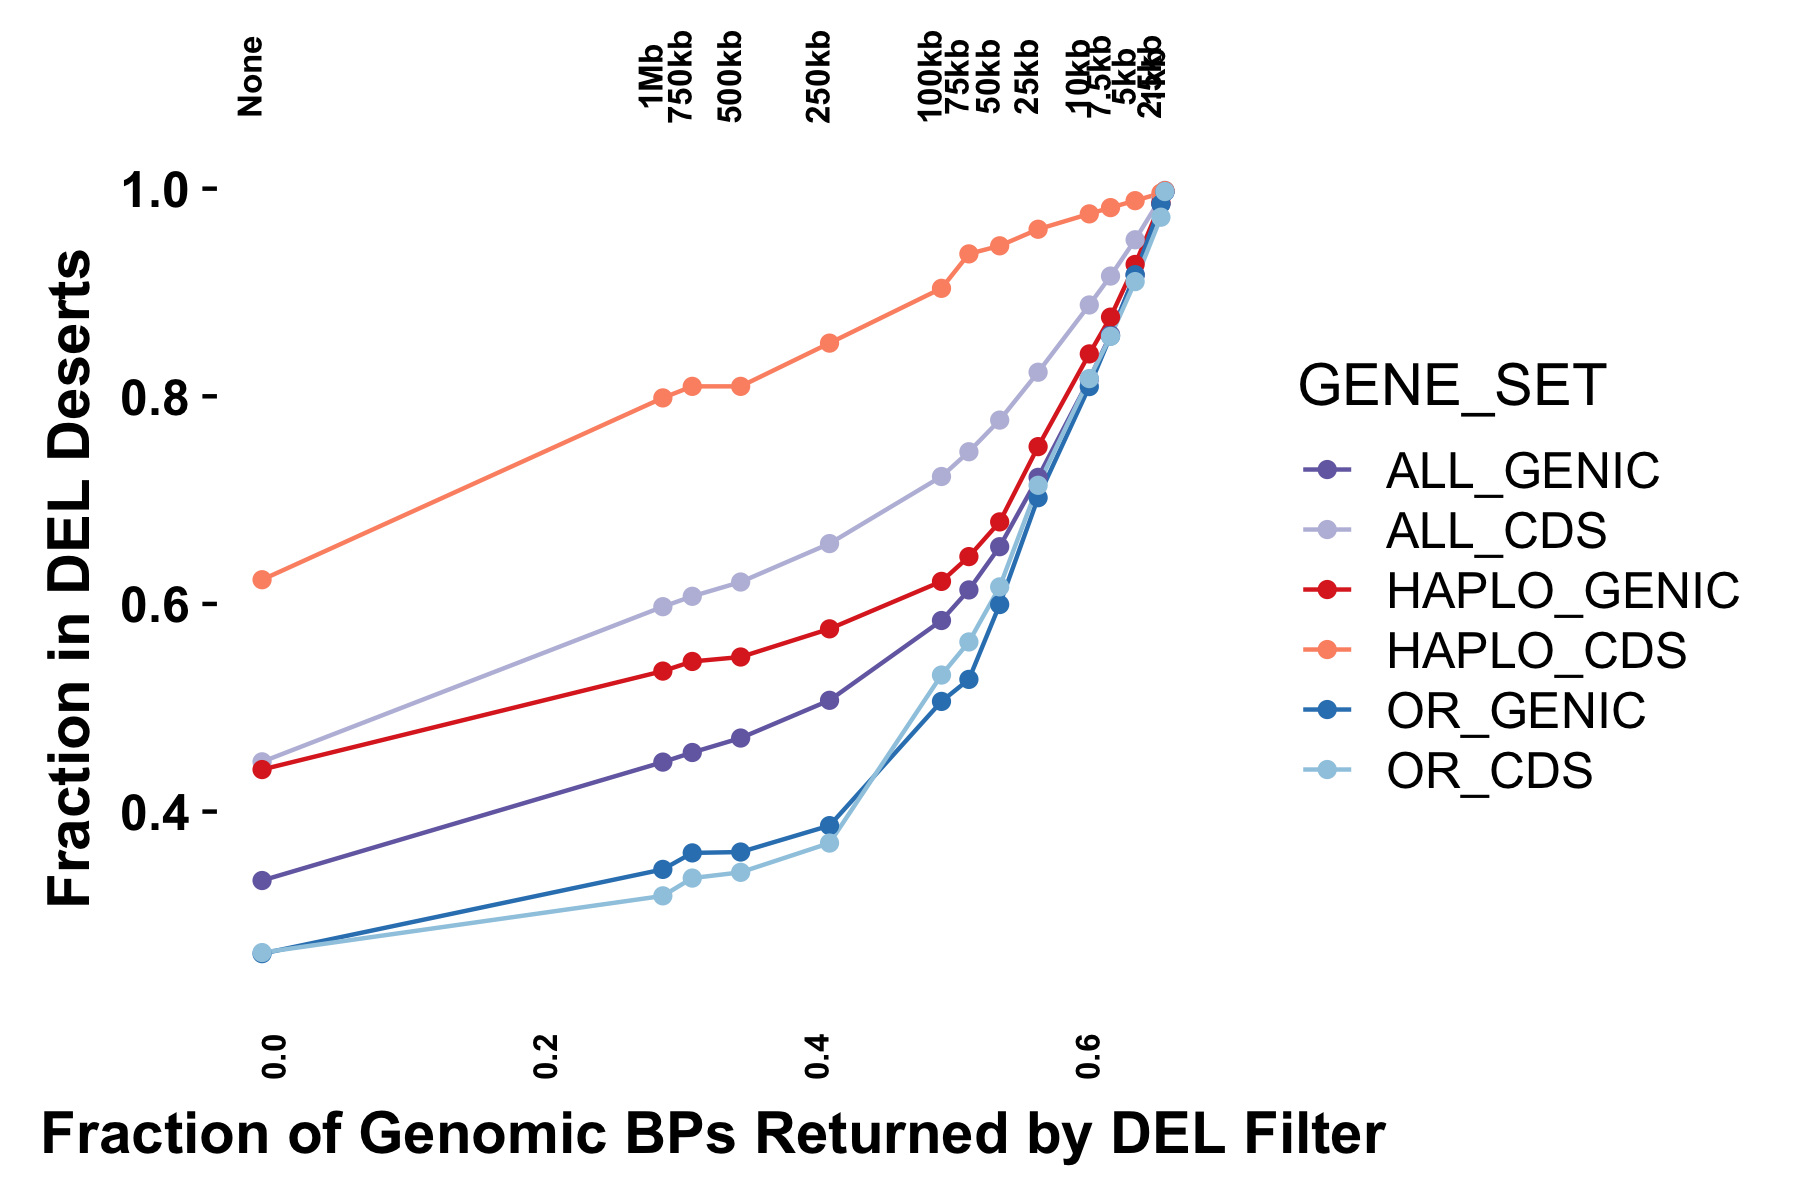

In [4]:
from IPython.display import Image # type: ignore

# Display the image in the Jupyter Notebook cell
Image(filename='fraction_in_DEL_deserts.png', width=800)

## Compute SNV scores of a set of positive and negative genes (i.e. genes that are known to be under negative selection or no selection) by using ONLY the exons of these genes


In [5]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" 
    f" -b <(tail -n +2 {b_filename})"
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)
  b_file_header = get_header(b_filename)

  return a_file_header, b_file_header

def assign_SNV_scores_to_labeled_genes(gene_class):
  a_filename = f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/canonical-exons.{gene_class}.sorted.bed'
  b_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/small-windows.bed'
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/{gene_class}-canonical-exons-intersect-chen-windows.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['exon_chen_overlap'],
  )

  df = df[df['chrom'] != '.'] # we don't want to include exons that don't overlap any Chen windows

  # though unlikely, some exons may intersect multiple Chen windows, 
  # so let's group by exon, and compute the min Chen score over all Chen windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'negative new chen zscore': [np.min],
    }
  )

  # group exons by parent gene, computing min z-score in each group
  df = aggregate(
    df, 
    group_columns = ['gene_symbol'],
    aggregation_functions = {
      'min negative new chen zscore': [np.min],
    }
  )

  # [TODO] possibly normalize by number of exons in each gene (this would make sense if the aggregate were a mean, but it's a min, so maybe not)

  return df 

assign_SNV_scores_to_labeled_genes(gene_class='positive')

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/positive-canonical-exons-intersect-chen-windows.bed


,gene_symbol,min min negative new chen zscore
0,AAGAB,-0.1018284540297633
1,AARS,-0.3548969274475289
2,ABCC9,-0.5352143859126356
3,ACTA2,-0.3258628160770033
4,ACTB,-0.0649063744934747
...,...,...
654,ZEB1,-0.0528935243005954
655,ZEB2,-1.144856811676365
656,ZFPM2,-0.4044405227787987
657,ZFYVE27,-0.7812804557883587


## Compute SV scores of a set of positive and negative genes (i.e. genes that are known to be under negative selection or no selection) by using ONLY the exons of these genes


In [7]:
# TODO 

#   df = pd.read_csv(
#     f"{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-{deletion_type}-deletions.bed", 
#     sep = '\t',
#   )  
#   df = df[
#     (df['chrom_window'] != 'chrX') &
#     (df['chrom_window'] != 'chrY')
#   ]

#   group_columns = [
#     'chrom_window',
#     'start_window',
#     'end_window',
#     'number_of_overlapping_topmed_deletions'
#   ]
#   aggregation_functions = {
#     'window_merged_deletion_overlap': [np.sum],
#   }
#   aggregation_columns = list(aggregation_functions.keys())
#   new_columns = group_columns + aggregation_columns
#   df = df[new_columns]
#   df = aggregate(df, group_columns, aggregation_functions)
  
#   df = df.rename(columns = {
#     'chrom_window': 'chrom',
#     'start_window': 'start',
#     'end_window': 'end',
#     'sum window_merged_deletion_overlap': 'large_window-merged_deletion overlap'
#   })

#   df.to_csv(
#     f"{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-{deletion_type}-deletions.aggregated.bed", 
#     sep = '\t',
#     index = False
#   )
  
#   return df 
  
# pd.set_option('display.max_rows', 1000)

# read_large_windows_intersect_all_deletions(
#   get_topmed_deletions_tail='get-common-topmed-deletions-tail', 
#   deletion_type='common'
# )

In [10]:
def assign_SV_scores_to_labeled_genes(gene_class, get_topmed_deletions_tail, deletion_type):
  windows = f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/canonical-exons.{gene_class}.sorted.bed'
  cmd = (
    f'bash '
    f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-windows-with-topmed-deletions.sh '
    f'{windows} '
    f'{get_topmed_deletions_tail} {deletion_type} '
    f'{LOWER_DELETION_SIZE_LIMIT} {UPPER_DELETION_SIZE_LIMIT} {DELETION_ALLELE_FREQ_THRESHOLD}'
  )
  # TODO 
  # continue from here: 
  print(shell(cmd))
  return 

  # TODO 
  #    group by parent genes, aggregate across exons (add counts, or get their min), to get deletion count for each gene (using only exons)
  # 5. [OPT] normalize deletion count by total exon length, so that we can compare across genes

  b_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/small-windows.bed'
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/{gene_class}-canonical-exons-intersect-chen-windows.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['exon_chen_overlap'],
  )

  df = df[df['chrom'] != '.'] # we don't want to include exons that don't overlap any Chen windows

  # though unlikely, some exons may intersect multiple Chen windows, 
  # so let's group by exon, and compute the min Chen score over all Chen windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'negative new chen zscore': [np.min],
    }
  )

  # group exons by parent gene, computing min z-score in each group
  df = aggregate(
    df, 
    group_columns = ['gene_symbol'],
    aggregation_functions = {
      'min negative new chen zscore': [np.min],
    }
  )

  # [TODO] possibly normalize by number of exons in each gene (this would make sense if the aggregate were a mean, but it's a min, so maybe not)

  return df 

assign_SV_scores_to_labeled_genes(
  gene_class='positive',
  get_topmed_deletions_tail='get-common-topmed-deletions-tail', 
  deletion_type='common'
)

chr1	6785454	6785575	CAMTA1	1	protein_coding	0
chr1	6820181	6820250	CAMTA1	2	protein_coding	0
chr1	6825092	6825210	CAMTA1	3	protein_coding	0
chr1	7091304	7091371	CAMTA1	4	protein_coding	0
chr1	7249491	7249626	CAMTA1	5	protein_coding	0
chr1	7467830	7467901	CAMTA1	6	protein_coding	0
chr1	7640400	7640553	CAMTA1	7	protein_coding	0
chr1	7661726	7661866	CAMTA1	8	protein_coding	0
chr1	7663353	7665199	CAMTA1	9	protein_coding	0
chr1	7670911	7671037	CAMTA1	10	protein_coding	0


Exception: [0;36mWe assume that the first line of the following is a header line: [0m/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/genes/grch38/canonical-exons.positive.sorted.bed

## TODO 

In [ ]:
# 6. re-run PR curves 

# 7. [DIFFICULT ???] repeat, but this time down-sample SNVs to the same number as deletions, so that we can compare them fairly. We might even find that SVs have better performance, since they are larger than SNVs, and thus have more power to detect a signal.

# 8. repeat, but this time don't aggregate exons across genes, and instead use exons as the unit of analysis, i.e. each exon is a positive or negative example, whose class we wish to predict

# 9. Visually inspect overlap of deletions with positive examples
